# 20211106 Feature Reduction
Going to try PCA, UMAP.

In [1]:
# notebook configuration
COLAB = False # will trigger manual installation of packages
USE_GPU = True 

In [2]:
# basic imports
from pathlib import Path
import os
import math
from datetime import datetime
import random

In [3]:
%matplotlib inline
%config Completer.use_jedi = False
os.environ['WANDB_NOTEBOOK_NAME'] = f"nb_{datetime.now().strftime('%Y%m%d')}.ipynb"

Now, non-stdlib imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# general ML tooling
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import log_loss, roc_auc_score
import wandb
from wandb.xgboost import wandb_callback
from wandb.lightgbm import wandb_callback
from sklearn.impute import SimpleImputer #, KNNImputer

import seaborn as sns

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.preprocessing import RobustScaler #StandardScaler #, MinMaxScaler, MaxAbsScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
# from sklearn.feature_selection import SelectKBest, f_regression
from joblib import dump, load
# feature engineering tools
# from sklearn.feature_selection import mutual_info_regression
# import featuretools as ft

from BorutaShap import BorutaShap

In [5]:
from pytorch_widedeep import Trainer
from pytorch_widedeep.preprocessing import WidePreprocessor, TabPreprocessor
from pytorch_widedeep.models import Wide, TabMlp, WideDeep#, SAINT, TabTransformer, TabNet, TabFastFormer, TabResnet
from pytorch_widedeep.metrics import Accuracy
from torchmetrics import AUROC
import torch
from torch.optim import Adam, AdamW, Adagrad, SGD, RMSprop, LBFGS
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts, CyclicLR, OneCycleLR, StepLR, CosineAnnealingLR
from pytorch_widedeep.callbacks import EarlyStopping, LRHistory, ModelCheckpoint

CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /tmp/pip-req-build-1_ic8ial/c10/cuda/CUDAFunctions.cpp:115.)


In [6]:
# import category_encoders as ce

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Now, datapath setup

In [7]:
if COLAB:
    # mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    
    # handling datapath
    datapath = Path('/content/drive/MyDrive/kaggle/tabular_playgrounds/nov2021/')
    
else:
    # if on local machine
#     datapath = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/sep2021/')  
    root = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/nov2021/')
    datapath = root/'datasets'
    # edapath = root/'EDA'
    # modelpath = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/oct2021/models/')
    predpath = root/'preds'
    subpath = root/'submissions'
    
    for pth in [datapath, predpath, subpath]:
        pth.mkdir(exist_ok=True)
    


In [8]:
SEED = 42

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(seed=SEED)

## Ex-Model Config

In [9]:
# meta-config for preprocessing and cross-validation, but NOT for model parameters
exmodel_config = {
#     "feature_selector": SelectKBest,
#     "k_best": 80,
#     "feature_selection_scoring": f_regression,
#     'random_state': SEED,
#     'feature_generation': ['NaN_counts', 'SummaryStats', 'NaN_OneHots'],
#     'subsample': 1,
    'cross_val_strategy': KFold, # None for holdout, or the relevant sklearn class
    'kfolds': 5, # if 1, that means just doing holdout
    'test_size': 0.2,
#     'features_created': False,
#     'feature_creator': None,
}

## Data Setup

**TODO** Write some conditional logic here to automate it -- possibly as part of a sklearn.*pipeline

In [10]:
# if exmodel_config['scaler']:
#     scaler = exmodel_config['scaler']()
#     scaler.fit_transform()

In [11]:
test_source = datapath/'test.feather'
# # test_source = altdatapath/'test-WITH-KMeans_12cluster_kmeans++_maxiter1000_rs42.feather' # altdatapath/'X_test_boruta_shap_200trials.feather'
exmodel_config['test_source'] = str(test_source)
X_test = pd.read_feather(path=test_source)
# # boruta = load(altdatapath/'boruta_shap.joblib')
# # X_test_enc = 
# # X_test = X_test.iloc[:, 1:] # only if loading the original test

In [12]:
# X_test = X_test.drop(['id'], axis=1)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [13]:
train_source = datapath/'X_orig.feather'
# train_source = altdatapath/'train-WITH-KMeans_12cluster_kmeans++_maxiter1000_rs42.feather' #'X_boruta_shap_200trials.feather'
# exmodel_config['train_source'] = str(train_source)
X = pd.read_feather(path=train_source)
# if 'target' in X.columns:
#     X = X.drop(['target'], axis=1)
# df.index.name = 'id'
# y = np.array(df.target)
y = load(datapath/'y_orig.joblib')
# features = [x for x in df.columns if x != 'target']
# X = df[features] # passing X as a pd.DataFrame to the trainer below, rather than as an np.ndarray
# X_train = df[features]
# X.index.name = 'id'
# y.index.name = 'id'


In [14]:
scaler = RobustScaler()
X_np = scaler.fit_transform(X)

In [15]:
X = pd.DataFrame(X_np, columns=X.columns, index=X.index)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# UMAP
Following directions [here](https://umap-learn.readthedocs.io/en/latest/basic_usage.html).

In [16]:
import umap

Tensorflow not installed; ParametricUMAP will be unavailable


In [17]:
# reducer = umap.UMAP()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [18]:
# umapper = reducer.fit(X)
# dump(reducer, datapath/'umap_reducer.joblib')

In [19]:
umapper = load(datapath/'umap_reducer.joblib')

In [20]:
# embedding = reducer.transform(X)
# embedding.shape
# dump(embedding, datapath/'X_orig-RobustScaled-umap_embedding.joblib')

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [21]:
embedding = load(datapath/'X_orig-RobustScaled-umap_embedding.joblib')

In [22]:
embedding_df = pd.DataFrame(embedding)
embedding_df.head()

,0,1
0,7.300986,-1.471326
1,-2.584028,-4.675673
2,1.659760,3.031258
3,3.443844,8.147803
4,0.353606,-2.166430


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


<AxesSubplot:xlabel='0', ylabel='1'>

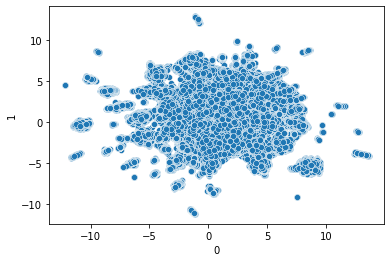

In [24]:
sns.scatterplot(x=embedding_df.iloc[:,0], y=embedding_df.iloc[:,1])